# SIFT clustering segmentation
-----
The method extract keypoints using sift and find the object by DBSCAN clustering. This version works on grayscale images. And it works well in this test

In [2]:
import os
from copy import deepcopy
from collections import Counter
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
%matplotlib inline


from sklearn.cluster import DBSCAN


sift = cv2.xfeatures2d.SIFT_create()

In [3]:
class channel:
    def __init__(self, kps=(), dists=(), angs=(), 
                 des=np.array(np.zeros([0, 128]), dtype='float32'), 
                 labels=(), sources=(), kps_ref=()):
        '''
        Warning: shallow copy for initialization.
        '''
        self.kps = tuple(kps)
        self.dists = tuple(dists)
        self.angs = tuple(angs)
        self.des = des
        self.labels = tuple(labels)
        self.sources = tuple(sources)
        self.kps_ref = tuple(kps_ref)
        if len(kps_ref) != 0:
            assert(len(kps) == len(kps_ref))
        return
    def copy(self):
        '''
        Copy method copy contents of itself and return a 
        new channel object.
        '''
        kps = deepcopy(self.kps)
        dists = deepcopy(self.dists)
        angs = deepcopy(self.angs)
        des = deepcopy(self.des)
        labels = deepcopy(self.labels)
        sources = deepcopy(self.sources)
        kps_ref = deepcopy(self.kps_ref)
        return channel(kps=kps, dists=dists, angs=angs, 
                       des=des, labels=labels, 
                       sources=sources, kps_ref=kps_ref)
    def merge(self, ch):
        '''
        Warning: The merge method shallow copy contents of 
        ch. It is assumed that the user will not use the 
        merged channel in the future.
        '''
        self.kps += ch.kps
        self.dists += ch.dists 
        self.angs += ch.dists
        self.des = np.vstack([self.des, ch.des])
        self.labels  += ch.labels
        self.sources  += ch.sources
        self.kps_ref += ch.kps_ref
        return
    
    def select(self, ind):
        '''
        Warning: select is shallow copy. Ind is a integer tuple of index.
        '''
        if len(self.kps) is not 0: kps = [self.kps[i] for i in ind]
        if len(self.dists) is not 0: dists = [self.dists[i] for i in ind]
        if len(self.angs) is not 0: angs = [self.angs[i] for i in ind]
        if len(self.sources) is not 0: sources = [self.sources[i] for i in ind]
        if len(self.labels) is not 0: labels = [self.labels[i] for i in ind]
        if np.size(self.des, 0) is not 0: des = np.asarray([self.des[i,:] for i in ind], dtype='float32')
        if len(self.kps_ref) is not 0: kps_ref = [self.kps_ref[i] for i in ind]
        return channel(kps=kps, dists=dists, angs=angs, des=des, labels=labels, sources=sources, kps_ref=kps_ref)

In [4]:
class item:
    def __init__(self, name, channel, eps=50, min_samples=5):
        '''
        an item object is instantiated with a name and a channel.
        eps and min_sample can be determined by size of source image
        '''
        self.name = name
        self.exists = False
        self.pt_c = np.asarray([0, 0])
        self.source = 'None'
        self.scale = 1
        self.orientation = 0
        self.pt_win = np.zeros([0,2])
        self.pt_raw = np.zeros([0,2])
        ch = self.valify(channel, eps, min_samples)
        ch = self.cluster(ch, 10, 5)
        self.source = self.voteForSource(ch.sources)
        return
    
    def valify(self, ch, eps, min_samples):
        first_presence_flag = [i for i, kp in enumerate(ch.kps) if kp not in ch.kps[:i]]
        ch = ch.select(first_presence_flag)
        if len(ch.kps) is 0:
            return ch
        pts = [kp.pt for kp in ch.kps]
        pt_raw, ind = self.voteForKps(pts, eps=eps, min_samples=min_samples)
        if len(ind) is 0:
            return ch
        ch = ch.select(ind)
        self.pt_raw = [kp.pt for kp in ch.kps]
        return ch
    
    def cluster(self, ch, eps, min_samples):
        if len(ch.kps) is 0:
            return ch
        self.scale = np.median([kp.size / kp_ref.size for kp, kp_ref in zip(ch.kps, ch.kps_ref)])
        self.centers = self.computeCenters(ch)
        pt_c, win = self.voteForKps(self.centers, eps=eps, min_samples=min_samples)
        if len(win) == 0:
            return ch
        ch.select(win)
        self.exists = True
        self.pt_c = pt_c
        self.pt_win = [kp.pt for kp in ch.kps]
        self.orientation = np.median([(kp1.angle - kp2.angle)%360 for kp1, kp2 in zip(ch.kps, ch.kps_ref)])
        return ch
    
    def computeCenters(self, ch):
        centers = []
        for i, kp in enumerate(ch.kps):
            x = kp.pt[0]
            y = kp.pt[1]
            ang = kp.angle + ch.angs[i]
            if ang < 0:
                ang += 360
            elif ang > 360:
                ang -=360
            x_c = x + self.scale * ch.dists[i] * np.cos(np.deg2rad(ang))
            y_c = y + self.scale * ch.dists[i] * np.sin(np.deg2rad(ang))
            centers.append([x_c, y_c])
        centers = np.asarray(centers)
        return centers
    
    
    def voteForCluster(self, pts, eps=100, min_samples=5):
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(pts)
        labels = db.labels_.astype('bool')
        labels = [not lb for lb in labels]
        if True not in labels:
            return [None, None, labels]
        XC = [pt[0] for i,pt in enumerate(pts) if labels[i]]
        YC = [pt[1] for i,pt in enumerate(pts) if labels[i]]
        return [XC, YC, labels]

    def voteForKps(self, pts, eps=100, min_samples=5):
        XC, YC, labels = self.voteForCluster(pts, eps=eps, min_samples=min_samples)
        ind = [i for i,v in enumerate(labels) if v]
        if len(ind) > 0:
            return [[np.median(XC), np.median(YC)], ind]
        else:
            return [[0, 0], ind]

    def voteForSource(self, sources):
        if len(sources) is 0:
            return 'None'
        c = Counter(sources)
        return c.most_common(1)[0][0]

    def makeBox(self):
        im = cv2.imread(self.source,0)
        r, c = im.shape
        dist = np.linalg.norm([r, c]) / 2 * self.scale
        theta = np.arctan2(r, c)
        orientation = self.orientation /180 * np.pi
        xc, yc = self.pt_c
        verts = [(dist * np.cos(theta + orientation) + xc, dist * np.sin(theta + orientation) + yc),
                 (dist * np.cos(-theta + orientation) + xc, dist * np.sin(-theta + orientation) + yc),
                 (dist * np.cos(-np.pi + theta + orientation) + xc, dist * np.sin(-np.pi + theta + orientation) + yc),
                 (dist * np.cos(np.pi - theta + orientation) + xc, dist * np.sin(np.pi - theta + orientation) + yc),
                 (dist * np.cos(theta + orientation) + xc, dist * np.sin(theta + orientation) + yc)]

        codes = [Path.MOVETO,
                 Path.LINETO,
                 Path.LINETO,
                 Path.LINETO,
                 Path.CLOSEPOLY]

        path = Path(verts, codes)
        return path

In [5]:
def computeVector(kps, img):
    dists = []
    angs = []
    for kp in kps:
        x = kp.pt[0]
        y = kp.pt[1]
        r, c = img.shape
        r_x = c//2 - kp.pt[0]
        r_y = r//2 - kp.pt[1]
        dist = np.linalg.norm([r_x, r_y])
        ang = (np.degrees(np.arctan2(r_y, r_x)) - kp.angle) % 360
        dists.append(dist)
        angs.append(ang)
    dists = dists
    angs = angs
    return [dists, angs]

In [6]:
def sift_detect(img, ind, source):
    sift = cv2.xfeatures2d.SIFT_create()
    kp, de = sift.detectAndCompute(img,None)
    dist, ang = computeVector(kp, img)
    label = [ind] * len(kp) # label for test_img is -1.
    return channel(kps=kp, dists=dist, angs=ang, des=de, labels=label, sources=source)

In [7]:
def train(root, ch):
    sift = cv2.xfeatures2d.SIFT_create()
    kps = []
    des = np.array(np.zeros([0, 128]), dtype='float32')
    labels = []
    sources = []
    classes = []
    
    dists = []
    angs = []
    _ = 0;
    for dir, subs, files in os.walk(root):
        if subs == []:
            classes.append(dir.replace(root,''))
            for f in files:
                if 'png' or 'jpg' in f:
                    img = cv2.imread(os.path.join(dir, f))
                    img = img[:,:,ch]
                    if img is None:
                        continue
                    kp, de = sift.detectAndCompute(img,None)
                    dist, ang = computeVector(kp, img)
                    #update
                    kps += kp
                    des = np.vstack([des, de])
                    labels += [_] * len(kp)
                    sources  += [os.path.join(dir, f)] * len(kp)                    
                    dists += dist
                    angs += ang
            _ += 1
    assert len(kps) == np.size(des, 0)
    assert len(labels) == np.size(des, 0)
    return channel(kps=kps, dists=dists, angs=angs, des=des, labels=labels, sources=sources), classes

In [8]:
root = '../data/items_300_pie/'
NCHANNEL = 3
chs = []
for i in range(NCHANNEL):
    ch,classes = train(root,i)
    chs.append(ch)

In [9]:
#copy test
ch1 = chs[1].copy()
print(len(ch1.kps), len(chs[1].kps))
#merge use shallow copy
ch1.merge(ch1)
print(len(ch1.kps))

1936 1936
3872


In [10]:
def flannMatch(des1, des2):
    # FLANN parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    # Need to draw only good matches, so create a mask
    matched = []
    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            matched.append([m.trainIdx, m.queryIdx])

    matched = np.array(matched).astype(int)
    return matched

In [11]:
def match(chs1, chs2):
    assert(len(chs1) == len(chs2))
    ch_matched = channel()
    for ch1, ch2 in zip(chs1, chs2):
        matched = flannMatch(ch1.des, ch2.des)
        
        kps = tuple([ch2.kps[ind] for ind in matched[:,0]])
        kps_ref = tuple([ch1.kps[ind] for ind in matched[:,1]])        

        dists = tuple([ch1.dists[ind] for ind in matched[:,1]])
        angs = tuple([ch1.angs[ind] for ind in matched[:,1]])
        des = np.asarray([ch2.des[ind] for ind in matched[:, 0]], dtype='float32')

        labels = tuple([ch1.labels[ind] for ind in matched[:,1]])
        sources = tuple([ch1.sources[ind] for ind in matched[:,1]])
        ch = channel(kps=kps, dists=dists, angs=angs, 
                   des=des, labels=labels, sources=sources,
                   kps_ref=kps_ref)
        ch_matched.merge(ch)
    return ch_matched, matched

# Single Item Test

In [40]:
root = '../data/items_300_Reynolds_Wrap/'
test = '../data/test_1000/test1.jpg'
NCHANNEL = 3
chs1 = []
for i in range(NCHANNEL):
    ch, classes = train(root,i)
    chs1.append(ch)

chs2 = []
imgTest = cv2.imread(test)
for i in range(NCHANNEL):
    ch = sift_detect(imgTest[:,:,i], -1, test)
    chs2.append(ch)
ch_matched, _ = match(chs1, chs2)

In [25]:
from functools import partial

In [26]:
def predict(ch_matched, classes):
    objs = []
    for i in np.unique(np.array(ch_matched.labels, dtype='int')):
        ind = np.where(np.array(ch_matched.labels, dtype='int') == i)[0]
        channel = ch_matched.select(ind)
        obj = item(classes[i], channel, eps=40, min_samples=5)
        objs.append(obj)
    return objs

In [27]:
objs = predict(ch_matched, classes)

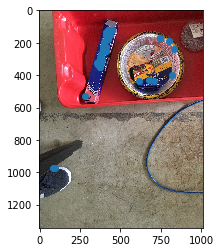

In [28]:
plt.imshow(imgTest[:,:,::-1])
pts = np.asarray([kp.pt for kp in ch_matched.kps], dtype='int')
plt.scatter(pts[:,0], pts[:,1])

(78, 2)


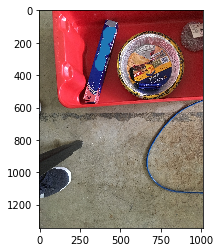

In [29]:
plt.imshow(imgTest[:,:,::-1])
obj = objs[0]
pt_raw = np.asarray(obj.pt_raw)
print(pt_raw.shape)
plt.scatter(pt_raw[:,0], pt_raw[:,1])

(78, 2)


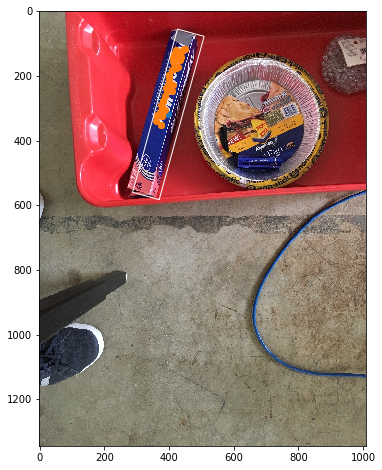

In [30]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(imgTest[:,:,::-1])
ax.scatter(obj.pt_c[0], obj.pt_c[1])
p = obj.makeBox()
box = patches.PathPatch(p, fc='none', ec='white')
ax.add_patch(box)
pt_win = np.asarray(obj.pt_win)
print(pt_win.shape)
plt.scatter(pt_win[:,0], pt_win[:,1])

# Multiple Item Test

In [ ]:
root = '../data/items_600/'
test = '../data/segmented_test/testimg0.png'
NCHANNEL = 3
chs1 = []
for i in range(NCHANNEL):
    ch, classes = train(root,i)
    chs1.append(ch)

chs2 = []
imgTest = cv2.imread(test)
for i in range(NCHANNEL):
    ch = sift_detect(imgTest[:,:,i], -1, test)
    chs2.append(ch)
ch_matched, _ = match(chs1, chs2)

In [ ]:
objs = predict(ch_matched, classes)

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(imgTest[:,:,::-1])
leg = [obj.name for obj in objs if obj.exists]
for obj in objs:
    if obj.exists:
        ax.plot(obj.pt_c[0], obj.pt_c[1],'^')
        pts = np.asarray(obj.pt_raw)
        ax.scatter(pts[:,0], pts[:,1])
        p = obj.makeBox()
        box = patches.PathPatch(p, fc='none')
        ax.add_patch(box)
        ax.legend(leg)
        print(obj.name)

In [91]:
print([(i, obj.name, len(obj.pt_raw)) for i,obj in enumerate(objs)])

[(0, 'Reynolds_Wrap', 0), (1, 'Irish_Spring_Soap', 0), (2, 'Marbles', 5), (3, 'Crayons', 28), (4, 'Hanes_Socks', 5), (5, 'Tennis_Ball_Container', 9), (6, 'Ice_Cube_Tray', 6), (7, 'Measuring_Spoons', 0), (8, 'Epsom_Salts', 0), (9, 'Burts_Bees_Baby_Wipes', 5), (10, 'Black_Fashion_Gloves', 5), (11, 'Hand_Weight', 0), (12, 'Composition_Book', 0), (13, 'Toilet_Brush', 0), (14, 'Avery_Binder', 0), (15, 'Speed_Stick', 9), (16, 'Table_Cloth', 0), (17, 'Hinged_Ruled_Index_Cards', 0), (18, 'White_Facecloth', 0), (19, 'Robots_DVD', 0), (20, 'Ticonderoga_Pencils', 6), (21, 'Tissue_Box', 0), (22, 'Scotch_Sponges', 0), (23, 'Laugh_Out_Loud_Jokes', 0), (24, 'Fiskars_Scissors', 0), (25, 'Mouse_Traps', 0), (26, 'Expo_Eraser', 0), (27, 'Windex', 7), (28, 'Band_Aid_Tape', 0), (29, 'Bath_Sponge', 9), (30, 'Duct_Tape', 0), (31, 'Robots_Everywhere', 0), (32, 'Balloons', 0), (33, 'Glue_Sticks', 0), (34, 'Flashlight', 0), (35, 'Colgate_Toothbrush_4PK', 0), (36, 'Poland_Spring_Water', 0), (37, 'Plastic_Wine_Gl

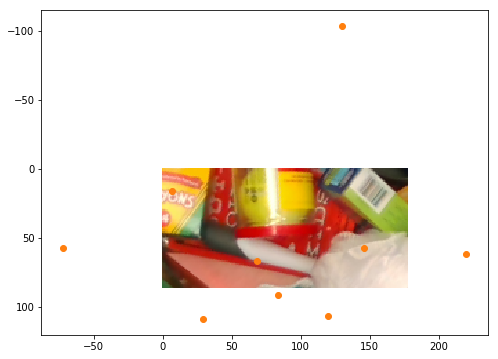

In [86]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(imgTest[:,:,::-1])
obj = objs[26]
pts = np.array(obj.pt_raw)
c = np.array(obj.centers)
ax.scatter(pts[:,0], pts[:,1])
ax.scatter(c[:,0], c[:,1])


In [87]:
obj = objs[29]
print(obj.name)
c = np.asarray(obj.centers)
print(c)

Bath_Sponge
[[  55.54320788   67.87163327]
 [  71.37085055  106.1504641 ]
 [  66.38458455   55.72246121]
 [ 187.98512805  -43.00795979]
 [ 101.04973996   64.2376256 ]
 [ 143.45404325  -65.34069214]
 [  71.20774765   81.44205217]
 [  67.66168389  105.65508596]
 [ 116.37119226  -39.90249503]
 [ 193.4929119    28.95097934]
 [  49.61962375   73.5680047 ]
 [  96.46402742   -3.35041475]
 [ 180.87966896  105.51359995]
 [  96.07743928    2.93613687]]
